### Advanced Regression Practice 
### Housing Price Prediction


In [103]:
# imports
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from col_mappings import mappings

# modeling 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

from scipy.stats import norm

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [104]:
cwd = os.getcwd()

file_path = os.path.join(cwd, "data", "train.csv")
train_df = pd.read_csv(file_path)

df = train_df.copy()

In [105]:
# Fill Alley NAs with "NA"
df["Alley"] = df["Alley"].fillna("No Fence")

# Replace LotFrontage NAs with 0 
df["LotFrontage"] = df["LotFrontage"].fillna(0)

# MasVnrType 
df["MasVnrType"] = df["MasVnrType"].fillna("None")

# MasVnrArea Fill 0 
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)

# No Basement fill 
basement_cols = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]

for col in basement_cols: 
    df[col] = df[col].fillna("No Basement")

# Fireplace 
df["FireplaceQu"] = df["FireplaceQu"].fillna("No Fireplace")

# GarageType
garage_cols = ["GarageType", "GarageFinish", "GarageQual", "GarageCond", "GarageYrBlt"]
for col in garage_cols: 
    if col == "GarageYrBlt": 
        df[col] = df[col].fillna(df["YearBuilt"]) # replace with the year that the house was built
        
    df[col] = df[col].fillna("No Garage")

# Drop PoolQC
df = df.drop("PoolQC", axis = 1)

# Fence
df["Fence"] = df["Fence"].fillna("No Fence")

# MiscFeature
df["MiscFeature"] = df["MiscFeature"].fillna("None")

# Convert MSSubClass to their Character Values
df["MSSubClass"] = df["MSSubClass"].map(mappings["MSSubClass"])

# Ordinal Vars to Cat 
ordinal_vars = ["OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd", "GarageYrBlt", "MoSold", "YrSold"]

for col in ordinal_vars: 
    df[col] = df[col].astype("category")


df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,2-STORY 1946 & NEWER,RL,65.0,8450,Pave,No Fence,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,No Fireplace,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,No Fence,None,0,2,2008,WD,Normal,208500
1,2,1-STORY 1946 & NEWER ALL STYLES,RL,80.0,9600,Pave,No Fence,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,No Fence,None,0,5,2007,WD,Normal,181500
2,3,2-STORY 1946 & NEWER,RL,68.0,11250,Pave,No Fence,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,No Fence,None,0,9,2008,WD,Normal,223500
3,4,2-STORY 1945 & OLDER,RL,60.0,9550,Pave,No Fence,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,No Fence,None,0,2,2006,WD,Abnorml,140000
4,5,2-STORY 1946 & NEWER,RL,84.0,14260,Pave,No Fence,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,No Fence,None,0,12,2008,WD,Normal,250000


In [106]:
for col in df.select_dtypes(include = "object").columns: 
    df[col] = df[col].astype("category")

#### EDA

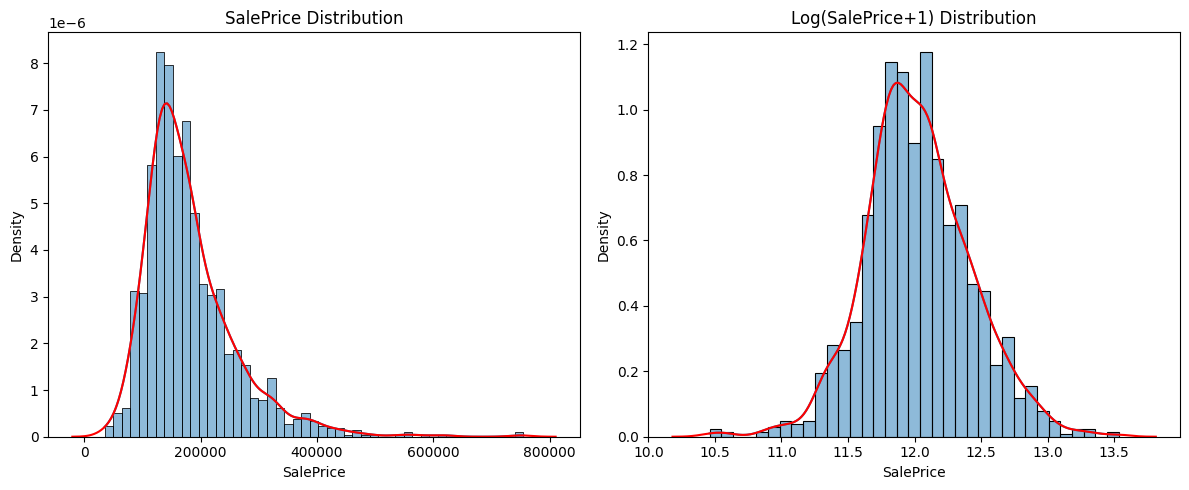

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Original distribution
sns.histplot(df["SalePrice"], kde=True, stat="density", ax=ax[0])
sns.kdeplot(df["SalePrice"], ax=ax[0], color="red")  # smooth curve
ax[0].set_title("SalePrice Distribution")

# Log-transformed distribution
sns.histplot(np.log1p(df["SalePrice"]), kde=True, stat="density", ax=ax[1])
sns.kdeplot(np.log1p(df["SalePrice"]), ax=ax[1], color="red")
ax[1].set_title("Log(SalePrice+1) Distribution")

plt.tight_layout()
plt.show()

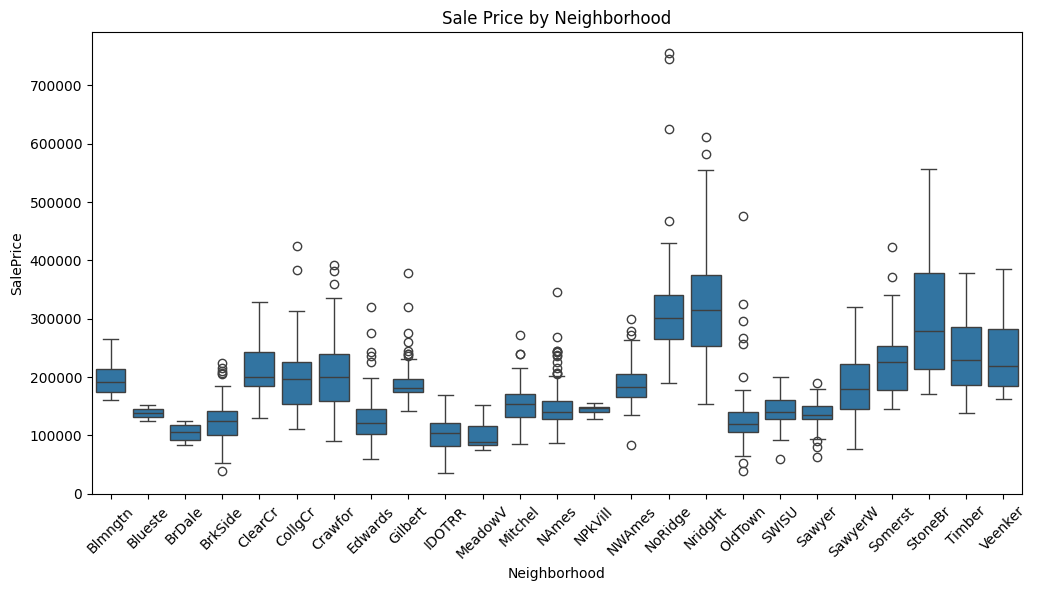

In [108]:
# Neighborhoods 
plt.figure(figsize=(12,6))
sns.boxplot(x = df["Neighborhood"], y = df["SalePrice"])
plt.title("Sale Price by Neighborhood")
plt.xlabel("Neighborhood")
plt.ylabel("SalePrice")
plt.xticks(rotation = 45)
plt.show()

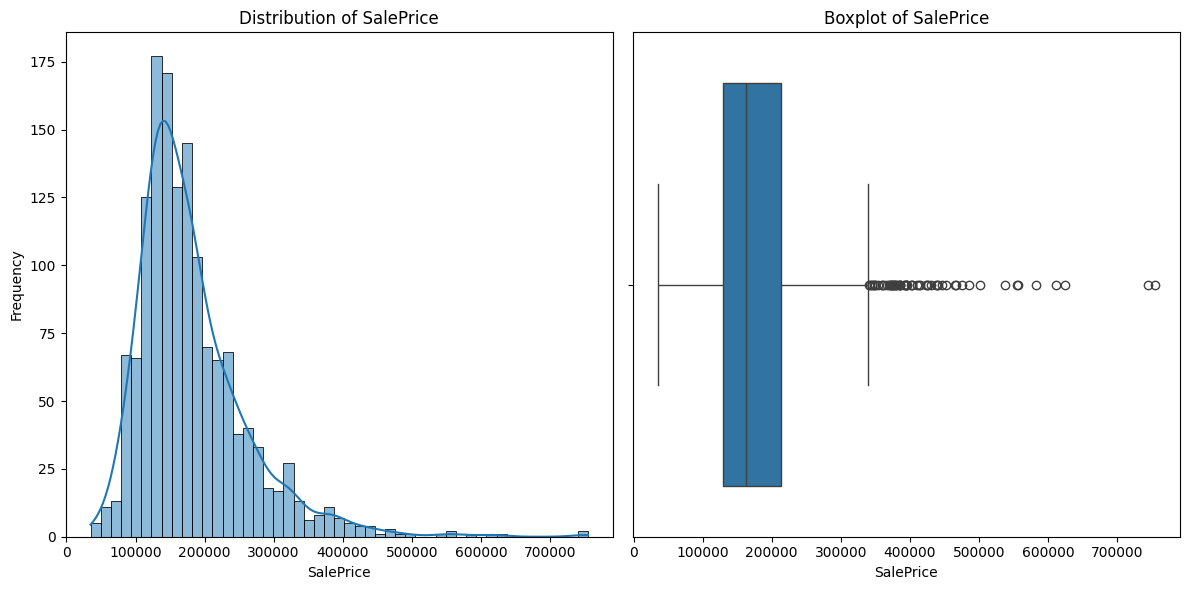

In [109]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.histplot(df["SalePrice"], kde = True)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
sns.boxplot(x = df["SalePrice"], orient = 'h')
plt.title("Boxplot of SalePrice")
plt.xlabel("SalePrice")

plt.tight_layout()
plt.show()

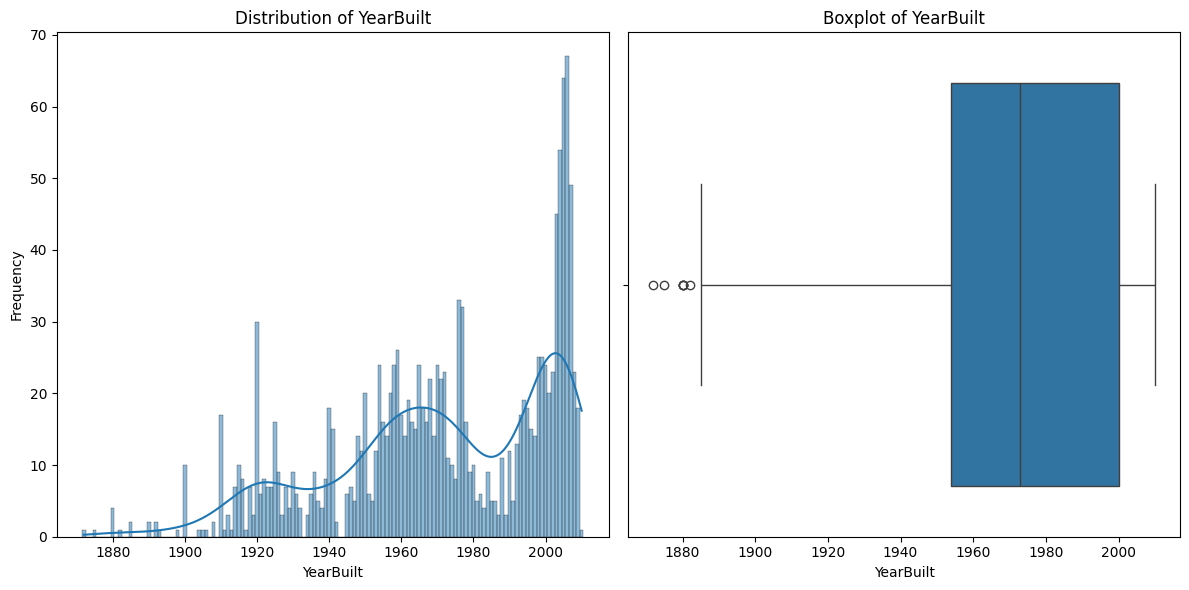

In [110]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.histplot(df["YearBuilt"], kde = True)
plt.title("Distribution of YearBuilt")
plt.xlabel("YearBuilt")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
sns.boxplot(x = df["YearBuilt"], orient = 'h')
plt.title("Boxplot of YearBuilt")
plt.xlabel("YearBuilt")

plt.tight_layout()
plt.show()

Consider: Log Transform, very heavy on the right

Lower bound: 399.375, Upper bound: 4886.375
Number of outliers: 20
1460
1440


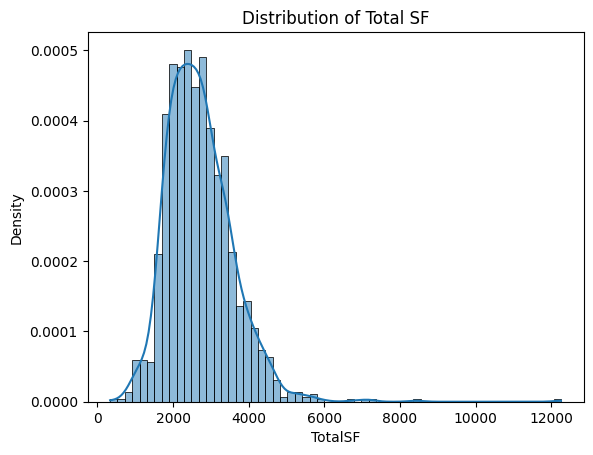

In [111]:
# Square Feet Data Engineering 
sf_columns = [col for col in df.columns if "SF" in col]

# Total Square Feet of the house 
df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"] + df["WoodDeckSF"] + df["OpenPorchSF"]

sns.histplot(df["TotalSF"], kde = True, stat = "density")
plt.title("Distribution of Total SF")

# We have a few homes that are huge outliers
def find_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25) 
    Q3 = df[column].quantile(0.75) 

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR 
    upper_bound = Q3 + 1.5 * IQR 

    outliers = df[(df[column] <= lower_bound) | (df[column] >= upper_bound)]
    return outliers, lower_bound, upper_bound

outliers, lb, ub = find_outliers_iqr(df, "TotalSF")
print(f"Lower bound: {lb}, Upper bound: {ub}")
print(f"Number of outliers: {len(outliers)}")
outliers

print(len(df))
df = df.drop(outliers.index)

print(len(df))

In [112]:
outliers, lb, ub = find_outliers_iqr(df, "LotFrontage")

outliers_sorted = pd.DataFrame(outliers, columns=df.columns).sort_values(by="LotFrontage")

outliers_sorted

# Handle LotFrontage Outlier ID == 935 
df = df.loc[df["LotFrontage"] != 935]

#### Analyze Which Columns may be removed

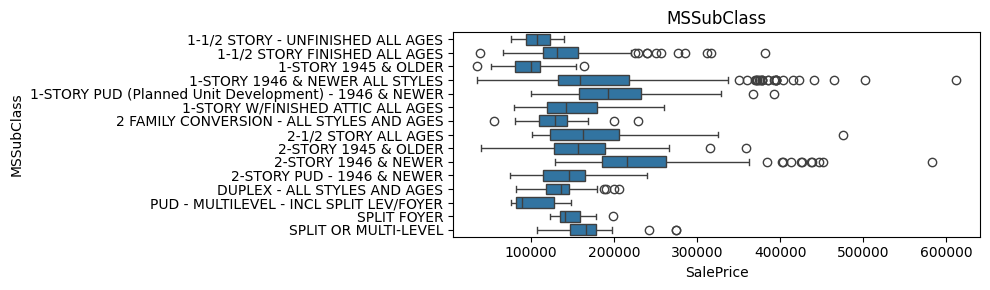

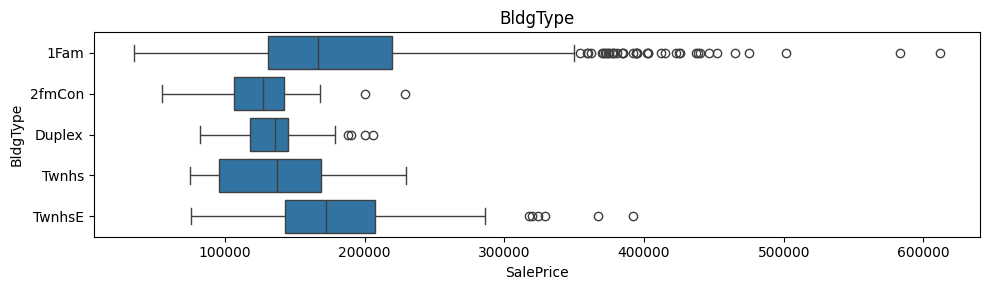

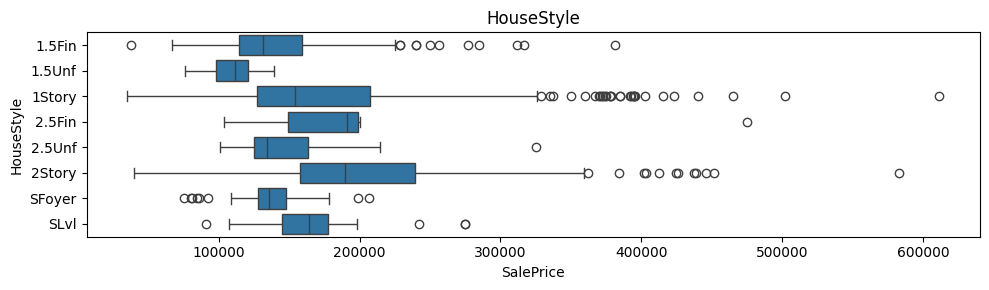

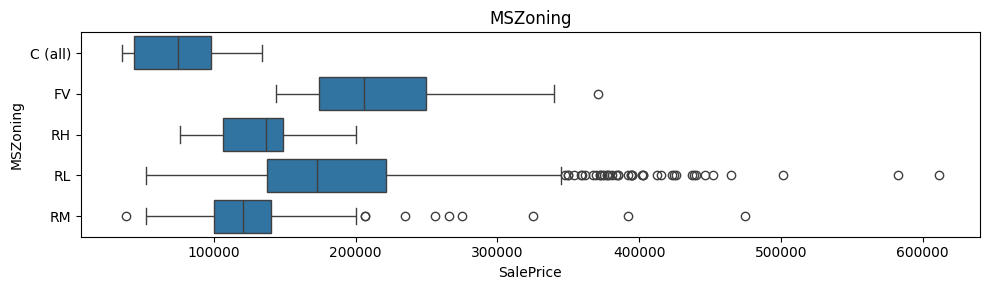

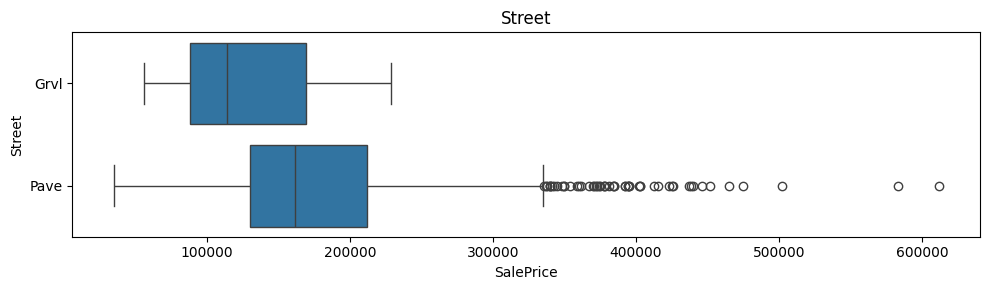

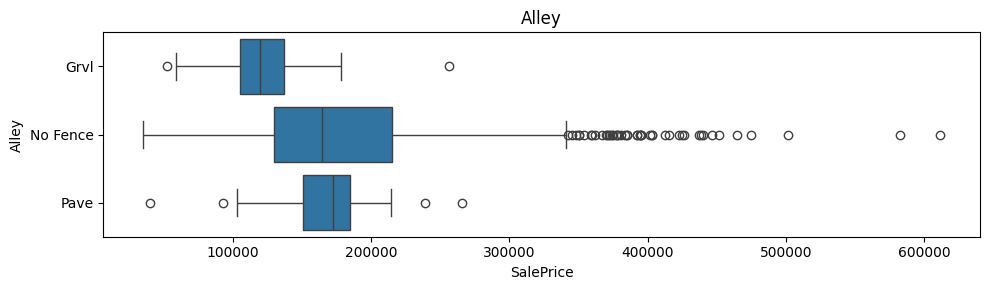

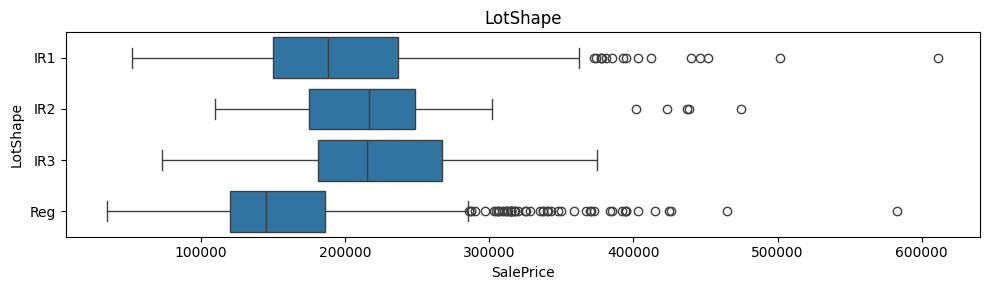

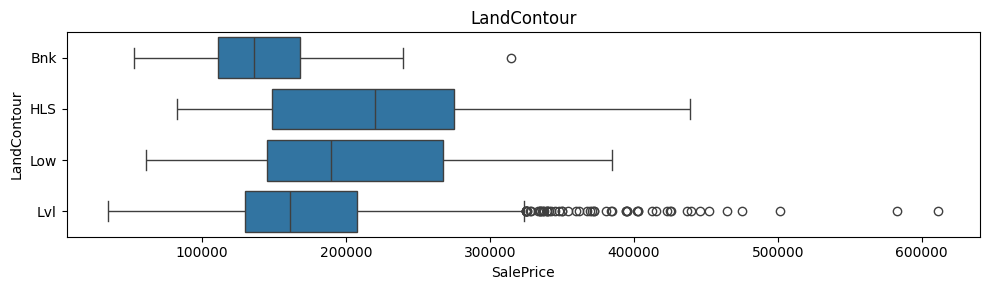

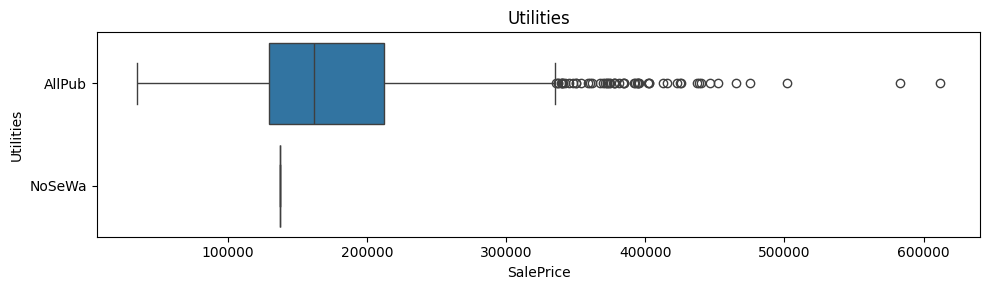

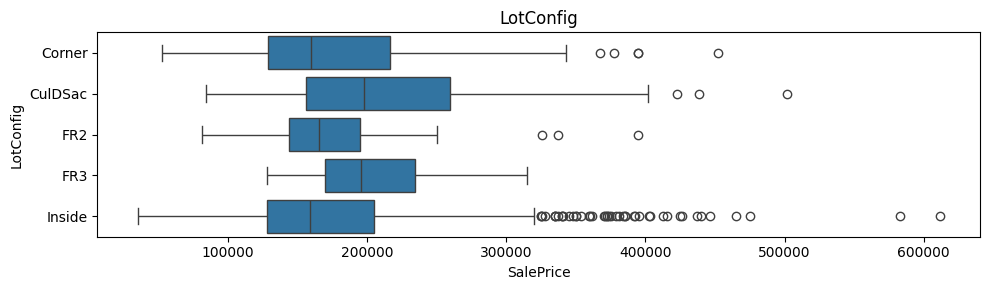

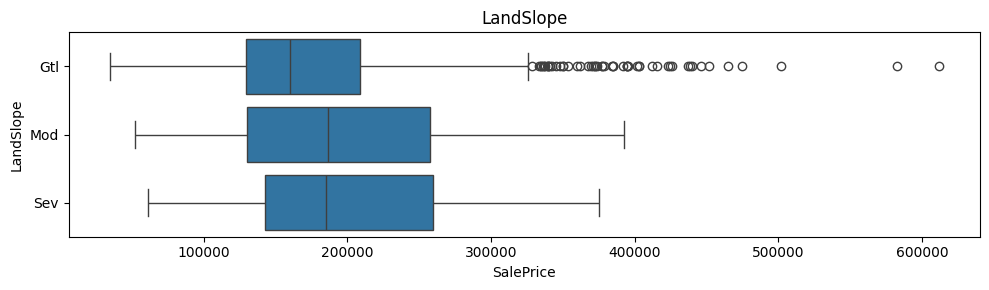

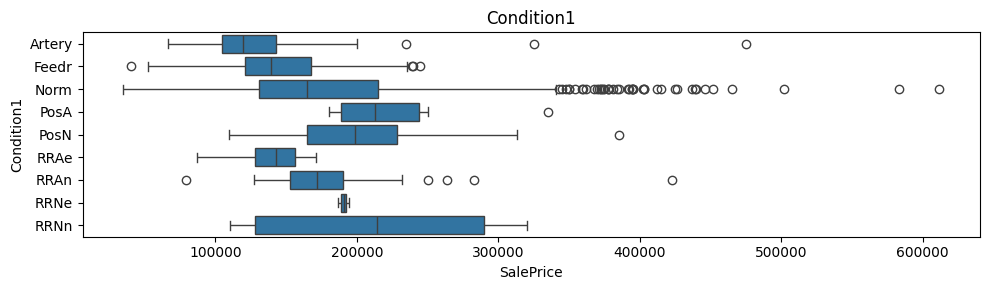

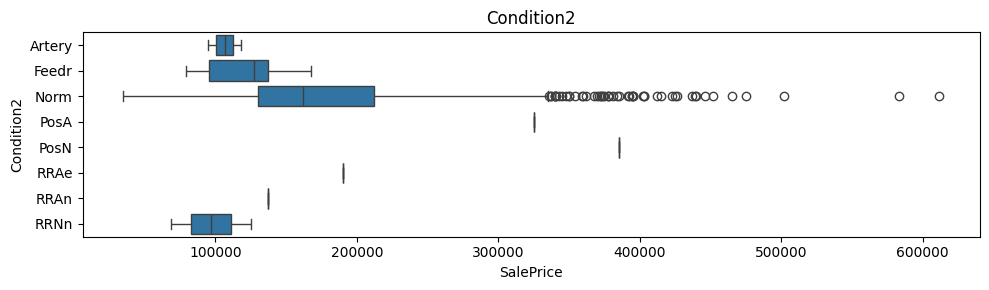

In [113]:
# MSSubClass (Type of Dwelling)
check_cols = ["MSSubClass", 
              "BldgType",
              "HouseStyle",
              "MSZoning", 
              "Street", 
              "Alley", 
              "LotShape", 
              "LandContour", 
              "Utilities", 
              "LotConfig",
              "LandSlope",
              "Condition1", 
              "Condition2"]

for col in check_cols:
    plt.figure(figsize=(10,3))
    sns.boxplot(x = "SalePrice", y =col, data = df, orient='h')
    plt.title(f"{col}")
    plt.tight_layout()
    plt.show()

In [114]:
# Columns to remove "Utilities", "LandSlope", ""

### Correlation Analysis

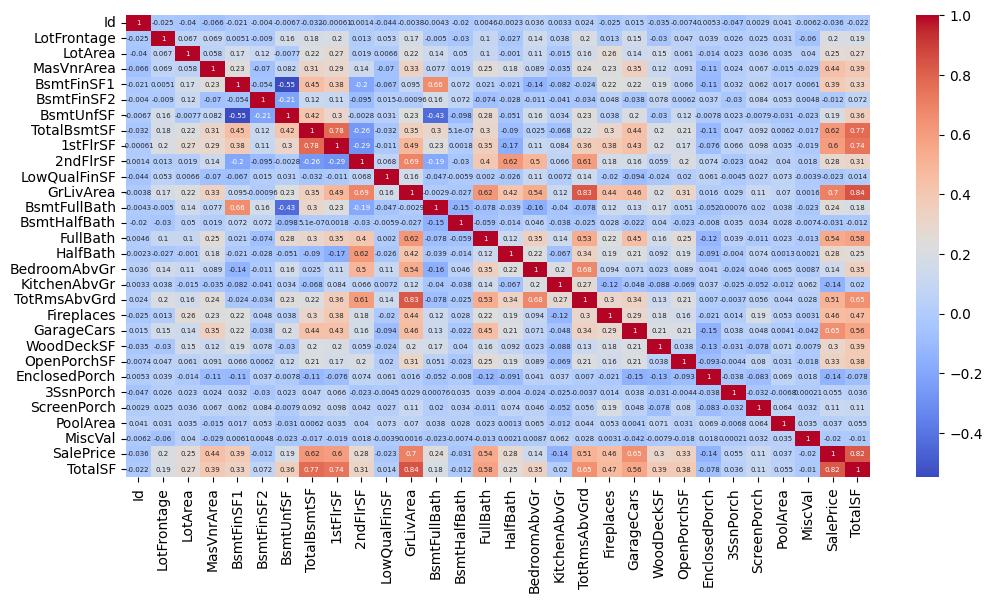

In [115]:
# Remove Garage Area 
df = df.drop(columns = ["GarageArea"])

plt.figure(figsize = (12,6)) 

sns.heatmap(df.corr(numeric_only=True), cmap = 'coolwarm', annot=True, annot_kws={"size": 5})
plt.show()

#### Modeling

In [139]:
X = df.drop(columns = ["SalePrice"])
y = df["SalePrice"]

cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

for col in cat_cols:
    X[col] = X[col].astype("category")

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

model = lgb.LGBMRegressor(
    n_estimators=1500, 
    learning_rate=0.062, 
    num_leaves=32, 
    max_depth = 1, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    # reg_alpha=0.5, # L1 penalty (LASSO)
    # reg_lambda=1.0, # L2 penalty (ridge)
    random_state=123, 
    n_jobs = -1,
    verbose = -1
)

callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=True)]

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="rmse",
    categorical_feature=cat_cols,
    callbacks=[
        lgb.early_stopping(100), 
        lgb.log_evaluation(period = 50)
    ]
)

pred = model.predict(X_valid, num_iteration=model.best_iteration_)
mse = mean_squared_error(y_valid, pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 32102.4	valid_0's l2: 1.03056e+09
[100]	valid_0's rmse: 28116.7	valid_0's l2: 7.90549e+08
[150]	valid_0's rmse: 26708.8	valid_0's l2: 7.13361e+08
[200]	valid_0's rmse: 25965.6	valid_0's l2: 6.74211e+08
[250]	valid_0's rmse: 25461.8	valid_0's l2: 6.48301e+08
[300]	valid_0's rmse: 25140.6	valid_0's l2: 6.3205e+08
[350]	valid_0's rmse: 24885.9	valid_0's l2: 6.19309e+08
[400]	valid_0's rmse: 24801.9	valid_0's l2: 6.15135e+08
[450]	valid_0's rmse: 24714.1	valid_0's l2: 6.10786e+08
[500]	valid_0's rmse: 24615	valid_0's l2: 6.05897e+08
[550]	valid_0's rmse: 24582	valid_0's l2: 6.04274e+08
[600]	valid_0's rmse: 24544.1	valid_0's l2: 6.02413e+08
[650]	valid_0's rmse: 24509.5	valid_0's l2: 6.00718e+08
[700]	valid_0's rmse: 24480.2	valid_0's l2: 5.99278e+08
[750]	valid_0's rmse: 24472.1	valid_0's l2: 5.98883e+08
[800]	valid_0's rmse: 24466.1	valid_0's l2: 5.98589e+08
[850]	valid_0's rmse: 24464.3	valid_0's l2: 5.98

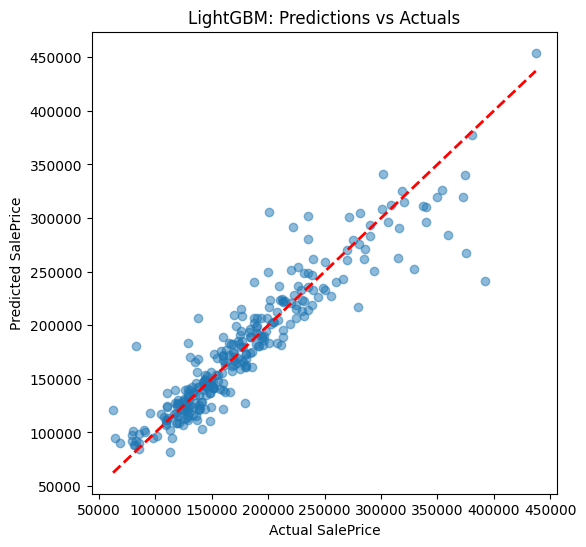

In [141]:
plt.figure(figsize=(6,6))
plt.scatter(y_valid, pred, alpha=0.5)
plt.plot([y_valid.min(), y_valid.max()],
         [y_valid.min(), y_valid.max()],
         'r--', lw=2)  # perfect prediction line
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("LightGBM: Predictions vs Actuals")
plt.show()

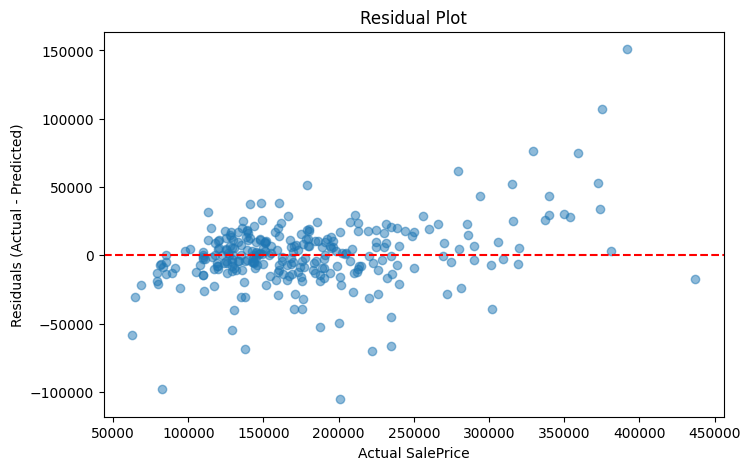

In [140]:
residuals = y_valid - pred

plt.figure(figsize=(8,5))
plt.scatter(y_valid, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Actual SalePrice")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

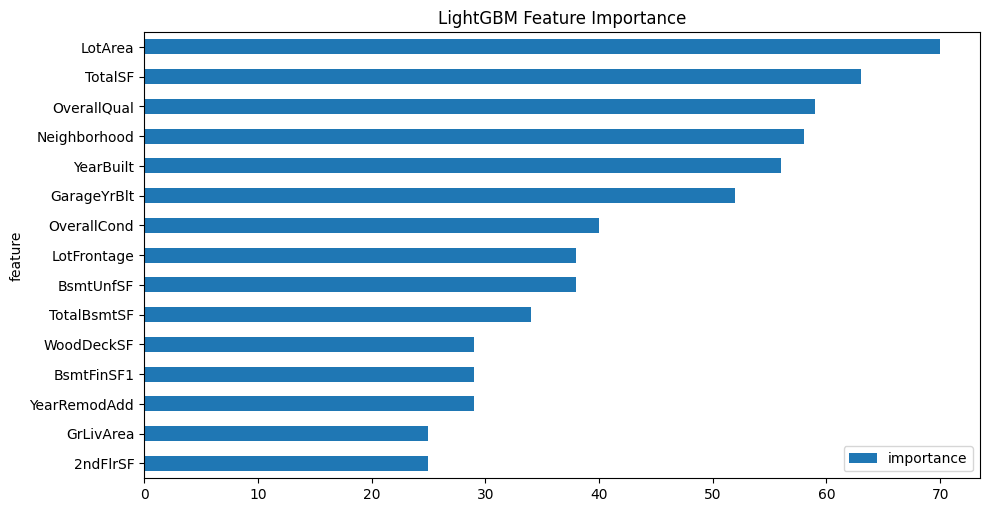

In [149]:
#### Feature Importance 

importance = model.feature_importances_
features = model.feature_name_

fi = pd.DataFrame({
    "feature": features, 
    "importance": importance
}).sort_values("importance", ascending=False)

fi.head(15).plot(kind = "barh", x = "feature", y="importance", figsize=(10,5), legend=True)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.title("LightGBM Feature Importance")
plt.show()

<Axes: ylabel='feature'>

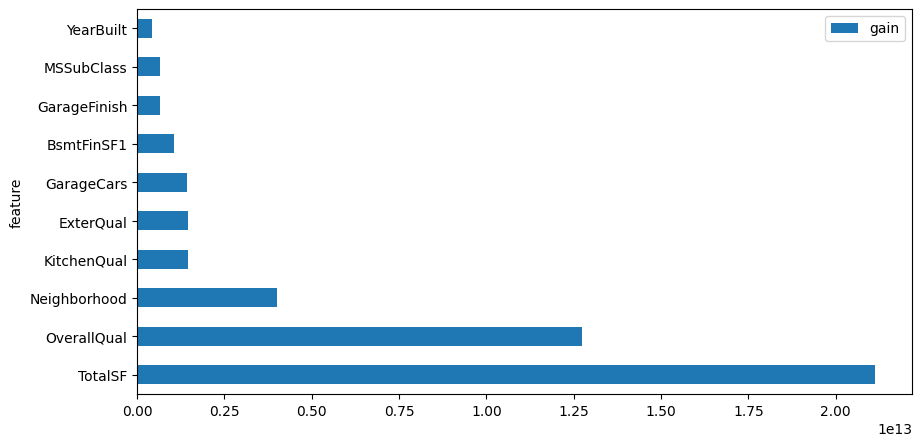

In [156]:
fi_gain = model.booster_.feature_importance(importance_type='gain')

fi_gain = pd.DataFrame({
    "feature": features, 
    "importance": importance,
    "gain": fi_gain
}).sort_values("gain", ascending=False)

fi_gain.head(10).plot(kind = 'barh', x = "feature", y = "gain", figsize=(10,5), legend = True)